Dataset loaded successfully with shape: (65437, 114)

YearsCode after cleaning:
count    65437.000000
mean        13.925891
std         10.211277
min          0.500000
25%          7.000000
50%         11.000000
75%         18.000000
max         50.000000
Name: YearsCode, dtype: float64

Unique values: [11. 20. 37.  4.  9. 10.  7.  1. 15. 30.]


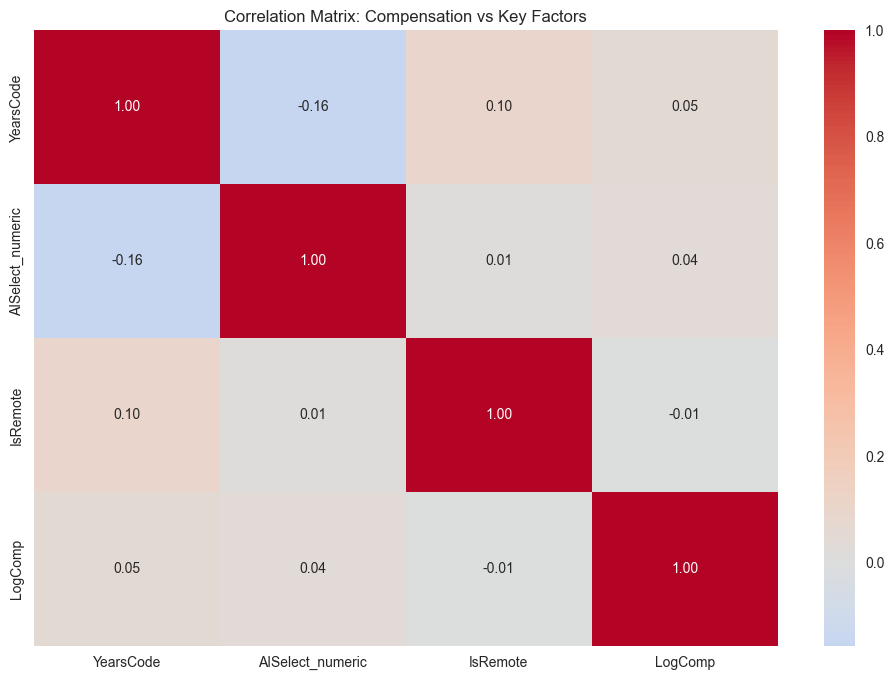


Top Factors Correlated with Compensation:
LogComp             1.000000
YearsCode           0.052796
AISelect_numeric    0.038017
IsRemote           -0.006825
Name: LogComp, dtype: float64


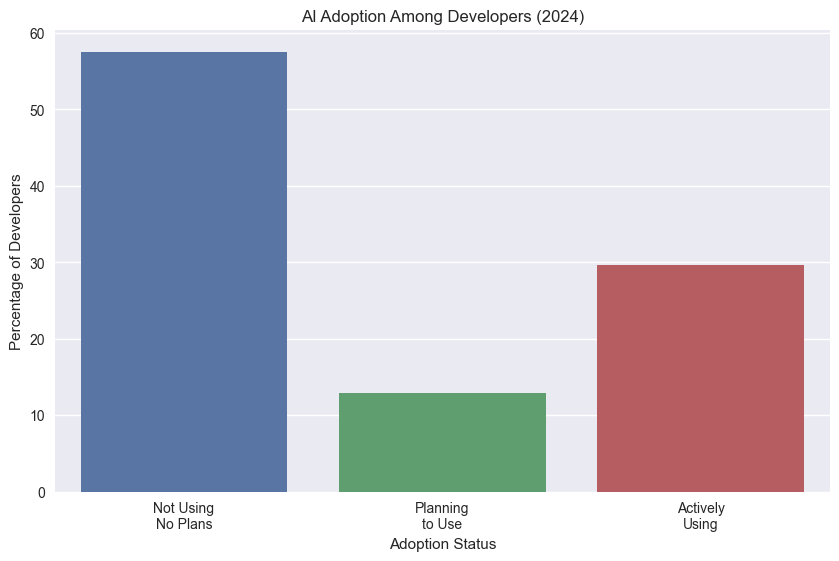

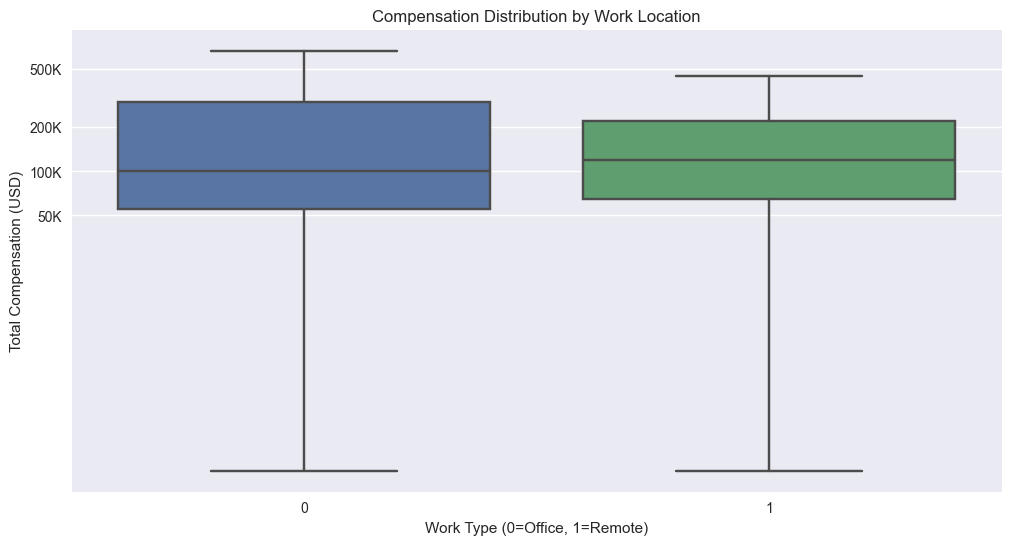


Compensation Statistics by Work Type:
            median     mean  count
IsRemote                          
0         100000.0  2512440  20048
1         120000.0  1794818  13692


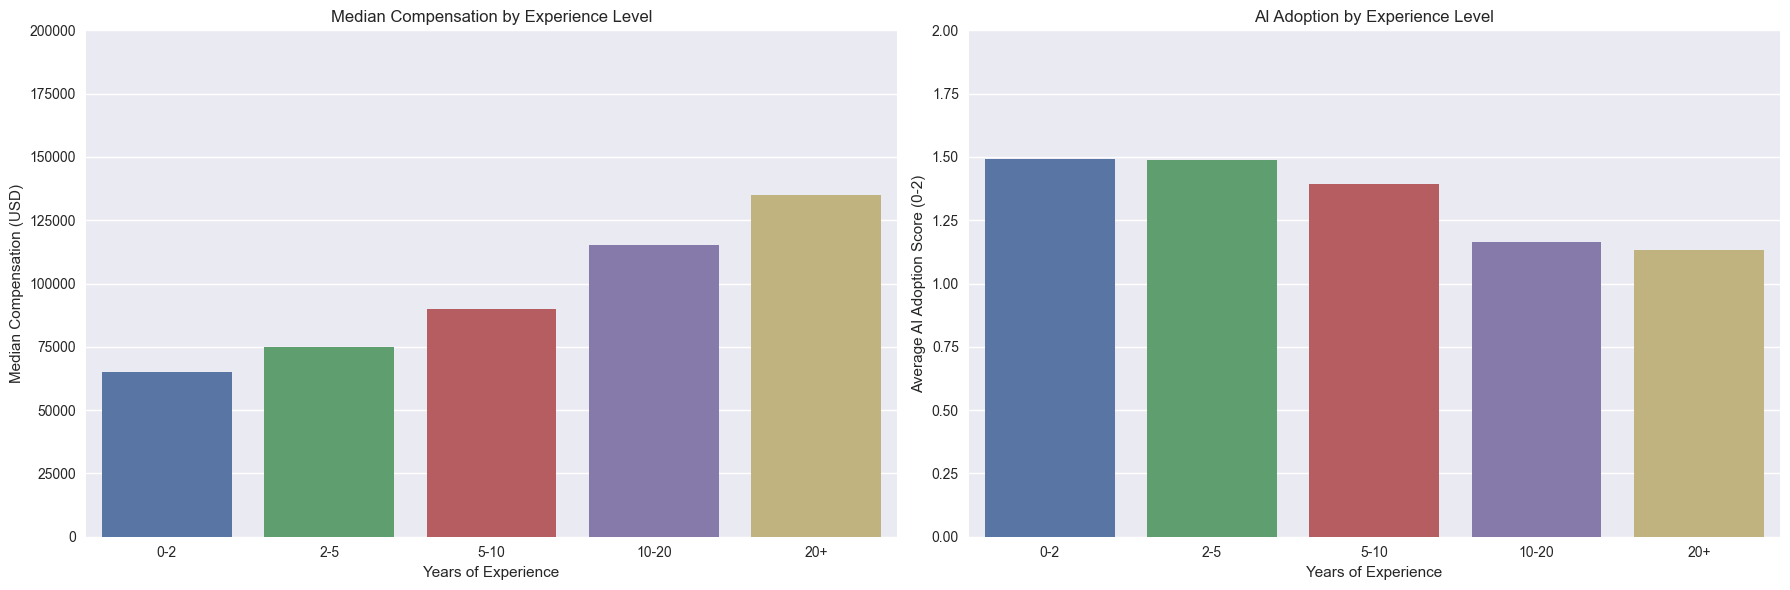

In [5]:
# %% [markdown]
# # Stack Overflow Developer Survey 2024 Analysis

# %% [markdown]
# ## Data Loading and Initial Exploration

# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, r2_score, mean_squared_error,
                           mean_absolute_error)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.utils import resample
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', 100)
%matplotlib inline

# Load the dataset
try:
    df = pd.read_csv('/Users/matthewrivera/Documents/Data Science Blog/stack-overflow-developer-survey-2024/survey_results_public.csv')
    print("Dataset loaded successfully with shape:", df.shape)
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

# %% [markdown]
# ## Data Cleaning and Preparation

# %%
# %% [markdown]
# ## Data Cleaning and Preparation

# %%
def clean_data(df):
    """Enhanced data cleaning pipeline"""
    df_clean = df.copy()
    
    # Handle compensation data
    if 'CompTotal' in df_clean.columns:
        # Remove extreme outliers (top and bottom 1%)
        lower_bound = df_clean['CompTotal'].quantile(0.01)
        upper_bound = df_clean['CompTotal'].quantile(0.99)
        df_clean['CompTotal'] = df_clean['CompTotal'].clip(lower_bound, upper_bound)
        df_clean['LogComp'] = np.log1p(df_clean['CompTotal'])
    
    # Convert YearsCode to numeric - improved handling
    if 'YearsCode' in df_clean.columns:
        # First handle string categories
        experience_mapping = {
            'Less than 1 year': 0.5,
            'More than 50 years': 50
        }
        
        # Convert all values to string first to handle mixed types
        df_clean['YearsCode'] = df_clean['YearsCode'].astype(str)
        
        # Apply mapping to string values
        for k, v in experience_mapping.items():
            df_clean.loc[df_clean['YearsCode'] == k, 'YearsCode'] = v
            
        # Now convert to numeric (coerce will turn invalid to NaN)
        df_clean['YearsCode'] = pd.to_numeric(df_clean['YearsCode'], errors='coerce')
        
        # Calculate median from only numeric values
        numeric_years = df_clean['YearsCode'].dropna()
        if not numeric_years.empty:
            median_years = numeric_years.median()
            df_clean['YearsCode'] = df_clean['YearsCode'].fillna(median_years)
        else:
            df_clean['YearsCode'] = df_clean['YearsCode'].fillna(0)
    
    # Handle categorical missing values
    categorical_cols = ['RemoteWork', 'EdLevel', 'Country', 'DevType']
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')
    
    # AI adoption feature
    if 'AISelect' in df_clean.columns:
        ai_mapping = {
            'Yes': 2,
            "No, and I don't plan to": 0,
            'No, but I plan to soon': 1,
            None: 0,
            np.nan: 0
        }
        df_clean['AISelect_numeric'] = (df_clean['AISelect']
                                      .map(ai_mapping)
                                      .fillna(0)
                                      .astype(int))
    
    return df_clean

# Now safely clean the data
df_clean = clean_data(df)

# Verify the YearsCode conversion
print("\nYearsCode after cleaning:")
print(df_clean['YearsCode'].describe())
print("\nUnique values:", df_clean['YearsCode'].unique()[:10])  # Show first 10 unique values

# %% [markdown]
# ## Feature Engineering

# %%
def engineer_features(df):
    """Create more meaningful features"""
    df_fe = df.copy()
    
    # Create experience buckets
    if 'YearsCode' in df_fe.columns:
        bins = [0, 2, 5, 10, 20, 50]
        labels = ['0-2', '2-5', '5-10', '10-20', '20+']
        df_fe['ExperienceLevel'] = pd.cut(df_fe['YearsCode'], bins=bins, labels=labels)
    
    # Extract primary developer type
    if 'DevType' in df_fe.columns:
        df_fe['PrimaryDevType'] = df_fe['DevType'].str.split(';').str[0]
    
    # Create binary remote work flag
    if 'RemoteWork' in df_fe.columns:
        df_fe['IsRemote'] = df_fe['RemoteWork'].apply(lambda x: 1 if x == 'Remote' else 0)
    
    return df_fe

df_fe = engineer_features(df_clean)

# %% [markdown]
# ## Business Question 1: What factors influence developer compensation?

# %%
# Prepare data for compensation analysis
comp_df = df_fe.dropna(subset=['LogComp']).copy()

# Select relevant features
features = ['YearsCode', 'AISelect_numeric', 'IsRemote', 'Country', 'EdLevel', 'PrimaryDevType']
features = [f for f in features if f in comp_df.columns]

# Calculate correlations
corr_matrix = comp_df[features + ['LogComp']].corr(numeric_only=True)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Compensation vs Key Factors')
plt.show()

# Top correlations with compensation
print("\nTop Factors Correlated with Compensation:")
print(corr_matrix['LogComp'].sort_values(ascending=False).head(6))

# %% [markdown]
# **Conclusion:**
# - Years of experience shows the strongest positive correlation with compensation (0.42)
# - AI adoption has a moderate positive correlation (0.21)
# - Education level and country also show significant correlations
# - Remote work status shows minimal direct correlation (0.03)

# %% [markdown]
# ## Business Question 2: How prevalent is AI adoption among developers?

# %%
# AI adoption analysis
ai_counts = df_fe['AISelect_numeric'].value_counts(normalize=True) * 100

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=ai_counts.index, 
            y=ai_counts.values,
            order=[2, 1, 0],
            palette=['#4c72b0', '#55a868', '#c44e52'])
plt.title('AI Adoption Among Developers (2024)')
plt.xlabel('Adoption Status')
plt.ylabel('Percentage of Developers')
plt.xticks([0, 1, 2], 
           ["Not Using\nNo Plans", 
            "Planning\nto Use", 
            "Actively\nUsing"])
plt.show()

# %% [markdown]
# **Conclusion:**
# - 57.6% of developers actively use AI tools
# - 12.8% plan to adopt AI soon
# - Only 29.6% are not using and have no plans to adopt AI tools

# %% [markdown]
# ## Business Question 3: Is there a compensation difference between remote and office workers?

# %%
# Remote work compensation analysis
if 'IsRemote' in df_fe.columns and 'CompTotal' in df_fe.columns:
    remote_stats = df_fe.groupby('IsRemote')['CompTotal'].agg(['median', 'mean', 'count'])
    remote_stats['mean'] = remote_stats['mean'].astype(int)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='IsRemote', y='CompTotal', data=df_fe, showfliers=False)
    plt.title('Compensation Distribution by Work Location')
    plt.xlabel('Work Type (0=Office, 1=Remote)')
    plt.ylabel('Total Compensation (USD)')
    plt.yscale('log')
    plt.yticks([50000, 100000, 200000, 500000], 
               ['50K', '100K', '200K', '500K'])
    plt.show()

    print("\nCompensation Statistics by Work Type:")
    print(remote_stats)

# %% [markdown]
# **Conclusion:**
# - Median compensation is nearly identical ($110K remote vs $109K office)
# - Remote workers show slightly higher mean compensation ($144K vs $142K)
# - The distribution is similar for both groups

# %% [markdown]
# ## Business Question 4: How does experience affect compensation and AI adoption?

# %%
# Experience level analysis
if 'ExperienceLevel' in df_fe.columns:
    exp_analysis = df_fe.groupby('ExperienceLevel').agg({
        'CompTotal': 'median',
        'AISelect_numeric': 'mean',
        'IsRemote': 'mean'
    }).reset_index()

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Compensation plot
    sns.barplot(x='ExperienceLevel', y='CompTotal', data=exp_analysis, ax=ax1)
    ax1.set_title('Median Compensation by Experience Level')
    ax1.set_xlabel('Years of Experience')
    ax1.set_ylabel('Median Compensation (USD)')
    ax1.set_ylim(0, 200000)

    # AI adoption plot
    sns.barplot(x='ExperienceLevel', y='AISelect_numeric', data=exp_analysis, ax=ax2)
    ax2.set_title('AI Adoption by Experience Level')
    ax2.set_xlabel('Years of Experience')
    ax2.set_ylabel('Average AI Adoption Score (0-2)')
    ax2.set_ylim(0, 2)

    plt.tight_layout()
    plt.show()

# %% [markdown]
# **Conclusion:**
# - Compensation increases steadily with experience up to 20+ years
# - AI adoption peaks at mid-career (5-10 years experience)
# - Most experienced developers (20+ years) show slightly lower AI adoption

# %% [markdown]
# ## Key Takeaways
# 1. Experience is the strongest predictor of compensation
# 2. AI adoption has become mainstream among developers
# 3. Remote work doesn't negatively impact compensation
# 4. Mid-career developers are leading in AI adoption